In [7]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import os
import dalex as dx

In [8]:
# =====================
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

X_train = train_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_train = train_df["HiringDecision"]

X_test = test_df.drop(["HiringDecision", "Age", "DistanceFromCompany", "Gender",'PreviousCompanies'], axis=1)
y_test = test_df["HiringDecision"]



In [9]:
test_df["HiringDecision"].value_counts()

HiringDecision
0    207
1     93
Name: count, dtype: int64

In [10]:
X_test.head()

,EducationLevel,ExperienceYears,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy
0,2,6,95,70,22,2
1,4,9,60,25,4,3
2,3,1,96,71,96,2
3,2,1,10,95,44,2
4,1,13,78,7,32,2


In [11]:
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)
loaded_pipeline = joblib.load("preprocesor.pkl")
loaded_model = joblib.load("best_xgboost_model.pkl")

# Gunakan pipeline untuk mentransformasi data baru secara langsung
# Data yang dimasukkan ke pipeline ini harus sama dengan kolom pada X_train

X_test_transformed = loaded_pipeline.transform(X_test)
feature_names = loaded_pipeline.get_feature_names_out()

X_test_transformed = pd.DataFrame(
    X_test_transformed,
    columns=feature_names,
    index=X_test.index
)

# Lakukan prediksi
prediction = loaded_model.predict(X_test_transformed)



In [12]:
X_test_transformed.head()

,num__InterviewScore,num__SkillScore,num__PersonalityScore,recruitment__RecruitmentStrategy_2,recruitment__RecruitmentStrategy_3,education__EducationLevel_2,education__EducationLevel_3,education__EducationLevel_4,experience__ExperienceYears_Mid,experience__ExperienceYears_Senior
0,1.530590,0.630528,-0.942264,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.306491,-0.900223,-1.553224,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.565564,0.664544,1.569459,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-1.442222,1.480945,-0.195535,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.936028,-1.512523,-0.602842,1.0,0.0,0.0,0.0,0.0,0.0,1.0


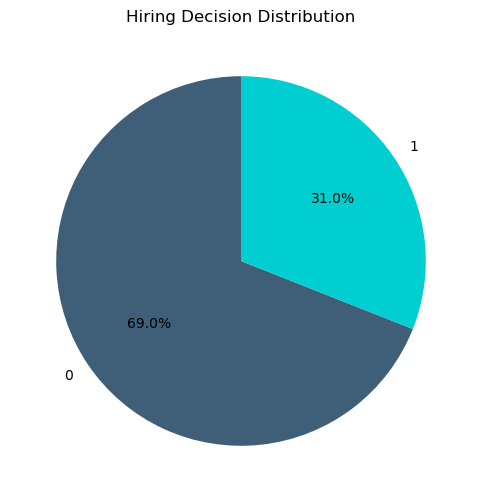

HiringDecision
0    207
1     93
Name: count, dtype: int64

In [13]:
custom_colors = ["#3E5F77", "#00CED1"]
total_hd=test_df['HiringDecision'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(
    total_hd,
    labels=total_hd.index,
    autopct='%1.1f%%',   # tampilkan persentase
    startangle=90,       # mulai dari atas
    colors= custom_colors # warna custom
)
plt.title("Hiring Decision Distribution")
plt.show()

total_hd

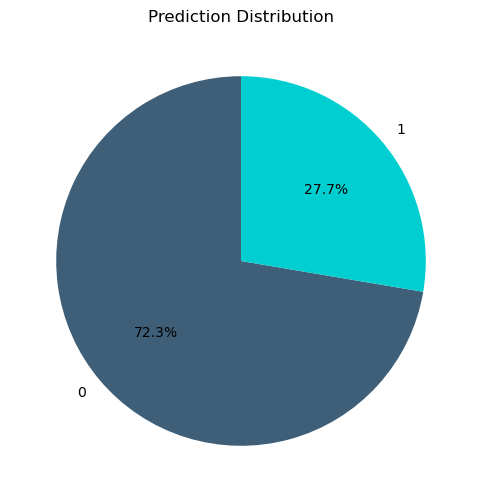

0    217
1     83
Name: count, dtype: int64

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Hitung distribusi hasil prediksi
total_pred = pd.Series(prediction).value_counts()

# Warna custom
custom_colors = ["#3E5F77", "#00CED1"]

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(
    total_pred,
    labels=total_pred.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=custom_colors
)
plt.title("Prediction Distribution")
plt.show()

total_pred


In [15]:
y_pred = loaded_model.predict(X_test_transformed)
y_prob = loaded_model.predict_proba(X_test_transformed)[:, 1]

## Demographic Parity

In [16]:
def demographic_parity(y_pred, sensitive_feature, mapping_dict=None):
    df = pd.DataFrame({"y_pred": y_pred, "group": sensitive_feature})
    
    # Hitung jumlah total, jumlah positif, dan positive_rate
    summary = df.groupby("group").agg(
        count=("y_pred", "size"),
        positives=("y_pred", "sum")
    )
    summary["positive_rate"] = summary["positives"] / summary["count"]
    
    # Kalau ada mapping dictionary, ganti index dengan nama kategori
    if mapping_dict is not None:
        summary.index = summary.index.map(mapping_dict)
    
    return summary


In [17]:
import pandas as pd

# ==== 1. Fungsi Demographic Parity ====
def demographic_parity(y_pred, sensitive_feature, mapping_dict=None):
    df = pd.DataFrame({"y_pred": y_pred, "group": sensitive_feature})
    
    # Hitung jumlah total, jumlah positif, dan positive_rate
    summary = df.groupby("group", observed=False).agg(
        count=("y_pred", "size"),
        positives=("y_pred", "sum")
    )
    summary["positive_rate"] = summary["positives"] / summary["count"]
    
    # Kalau ada mapping dictionary, ganti index dengan nama kategori
    if mapping_dict is not None:
        summary.index = summary.index.map(mapping_dict)
    
    return summary



# ==== 2. Mapping kategori untuk Education & Recruitment ====
edu_map = {
    1: "1.HighSchool",
    2: "2.Bachelor",
    3: "3.Master",
    4: "4.PhD"
}

recruit_map = {
    1: "1.Agresif (Headhunter)",
    2: "2.Moderat (Online/Jobportal)",
    3: "3.Konservatif (Offline/Walk-in)"
}

# ==== 3. Binning untuk Experience ====
def bin_experience(v):
    if v <= 2:
        return "Exp_Junior"
    elif v <= 5:
        return "Exp_Mid"
    else:
        return "Exp_Senior"

X_test["ExperienceLevel"] = X_test["ExperienceYears"].apply(bin_experience)


# ==== 4. Quantile Binning untuk Numeric Scores ====
def bin_by_quantile(series, labels=["Low", "Medium", "High"]):
    return pd.qcut(series, q=3, labels=labels, duplicates="drop")

for col in ["InterviewScore", "SkillScore", "PersonalityScore"]:
    X_test[f"{col}_bin"] = bin_by_quantile(X_test[col])


# ==== 5. Hitung Demographic Parity ====
dp_edu     = demographic_parity(y_pred, X_test["EducationLevel"], mapping_dict=edu_map)
dp_recruit = demographic_parity(y_pred, X_test["RecruitmentStrategy"], mapping_dict=recruit_map)
dp_exp     = demographic_parity(y_pred, X_test["ExperienceLevel"])

dp_interview = demographic_parity(y_pred, X_test["InterviewScore_bin"])
dp_skill     = demographic_parity(y_pred, X_test["SkillScore_bin"])
dp_person    = demographic_parity(y_pred, X_test["PersonalityScore_bin"])



In [18]:
# ==== Fungsi untuk konversi hasil DP ke long format ====
def dp_to_long(dp_table, feature_name):
    df = dp_table.reset_index().rename(columns={"group": "Subset"})
    df.insert(0, "Feature", feature_name)  # tambahkan kolom Feature paling depan
    return df


# ==== Gabungkan semua hasil DP jadi satu ====
dp_all = pd.concat([
    dp_to_long(dp_recruit, "RecruitmentStrategy"),
    dp_to_long(dp_edu, "EducationLevel"),
    dp_to_long(dp_exp, "ExperienceLevel"),
    dp_to_long(dp_interview, "InterviewScore"),
    dp_to_long(dp_skill, "SkillScore"),
    dp_to_long(dp_person, "PersonalityScore"),
], ignore_index=True)

# ==== Tampilkan ====
display(dp_all)

# # Nama folder yang diinginkan
folder_path = 'file_exp'

# # Cek apakah folder sudah ada, jika tidak, buat folder tersebut
# if not os.path.exists(folder_path):
#     os.path.makedirs(folder_path)
#     print(f"Folder '{folder_path}' berhasil dibuat.")

# # Buat path lengkap untuk file Excel
# file_path = os.path.join(folder_path, 'dp_all.xlsx')

# # Asumsikan 'hasil_evaluasi' adalah DataFrame
# dp_all.to_excel(file_path, index=True)

# print(f"Hasil evaluasi telah berhasil disimpan ke: {file_path}")


,Feature,Subset,count,positives,positive_rate
0,RecruitmentStrategy,1.Agresif (Headhunter),94,68,0.723404
1,RecruitmentStrategy,2.Moderat (Online/Jobportal),150,11,0.073333
2,RecruitmentStrategy,3.Konservatif (Offline/Walk-in),56,4,0.071429
3,EducationLevel,1.HighSchool,59,11,0.186441
4,EducationLevel,2.Bachelor,139,26,0.187050
5,EducationLevel,3.Master,74,35,0.472973
6,EducationLevel,4.PhD,28,11,0.392857
7,ExperienceLevel,Exp_Junior,59,13,0.220339
8,ExperienceLevel,Exp_Mid,50,9,0.180000
9,ExperienceLevel,Exp_Senior,191,61,0.319372


## Predict Proba 


In [19]:
# ==== 1. Average Predicted Probability per Group (Lebih Informatif) ====
def avg_predicted_proba(y_proba, sensitive_feature, mapping_dict=None):
    df = pd.DataFrame({"y_proba": y_proba, "group": sensitive_feature})
    if mapping_dict:
        df["group"] = df["group"].map(mapping_dict)
    summary = df.groupby("group").agg(
        samples=("y_proba", "size"),
        mean_proba=("y_proba", "mean"),
        std_proba=("y_proba", "std"),
        min_proba=("y_proba", "min"),
        max_proba=("y_proba", "max")
    )
    summary["mean_proba"] = summary["mean_proba"].round(3)
    summary["std_proba"] = summary["std_proba"].round(3)
    summary["min_proba"] = summary["min_proba"].round(3)
    summary["max_proba"] = summary["max_proba"].round(3)
    return summary.reset_index()


# ==== Contoh Pemakaian ====

# Education Level
avg_proba_edu = avg_predicted_proba(y_prob, X_test["EducationLevel"], mapping_dict=edu_map)
display(avg_proba_edu)

# Recruitment Strategy
avg_recruit = avg_predicted_proba(y_prob, X_test["RecruitmentStrategy"], mapping_dict=recruit_map)
display(avg_recruit)

# Experience Level
avg_exp = avg_predicted_proba(y_prob, X_test["ExperienceLevel"])
display(avg_exp)


,group,samples,mean_proba,std_proba,min_proba,max_proba
0,1.HighSchool,59,0.203,0.287,0.003,0.949
1,2.Bachelor,139,0.222,0.280,0.001,0.987
2,3.Master,74,0.473,0.369,0.007,0.998
3,4.PhD,28,0.397,0.328,0.011,0.991


,group,samples,mean_proba,std_proba,min_proba,max_proba
0,1.Agresif (Headhunter),94,0.655,0.278,0.077,0.998
1,2.Moderat (Online/Jobportal),150,0.133,0.184,0.001,0.958
2,3.Konservatif (Offline/Walk-in),56,0.135,0.211,0.001,0.948


,group,samples,mean_proba,std_proba,min_proba,max_proba
0,Exp_Junior,59,0.239,0.293,0.001,0.955
1,Exp_Mid,50,0.245,0.281,0.003,0.939
2,Exp_Senior,191,0.328,0.347,0.006,0.998


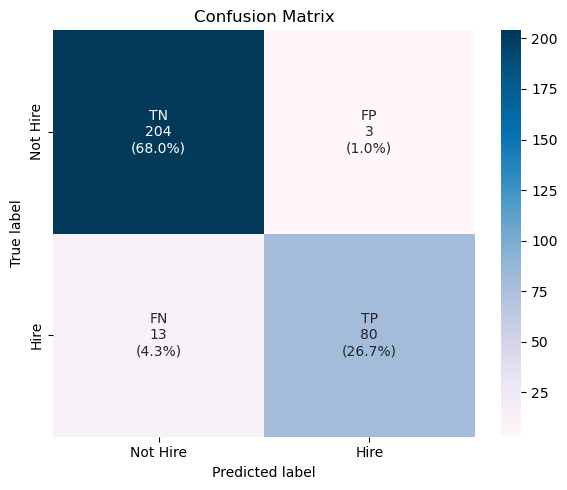

In [20]:
cm = confusion_matrix(y_test, prediction)
cm_sum = np.sum(cm)
cm_perc = cm / cm_sum * 100

# === TP, FP, FN, TN positions ===
group_names = np.array([["TN", "FP"],
                        ["FN", "TP"]])

# === Create combined label: label \n percentage ===
labels = np.array([["{0}\n{1:,}\n({2:.1f}%)".format(name, val, perc)
                    for name, val, perc in zip(group_row, cm_row, perc_row)]
                   for group_row, cm_row, perc_row in zip(group_names, cm, cm_perc)])

# === Plot heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='',cmap='PuBu', cbar=True,
            xticklabels=["Not Hire", "Hire"],
            yticklabels=["Not Hire", "Hire"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

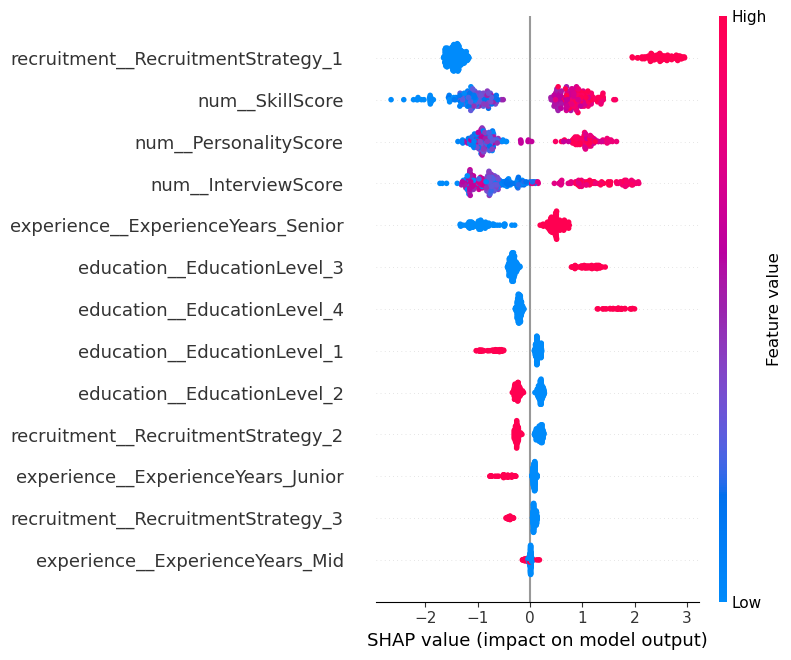

In [21]:
import shap
def bin_experience(x):
    bins = np.array(x).astype(int).ravel()
    labels = []
    for v in bins:
        if v <=2:
            labels.append("Junior")
        elif v <=5:
            labels.append("Mid")
        else:
            labels.append("Senior")
    return np.array(labels).reshape(-1,1)

load_pipeline = joblib.load("preprocesor_none.pkl")
load_model = joblib.load("best_xgboost_model_none.pkl")

# Gunakan pipeline untuk mentransformasi data baru secara langsung
# Data yang dimasukkan ke pipeline ini harus sama dengan kolom pada X_train

X_test_trans= load_pipeline.transform(X_test)
feature_names = load_pipeline.get_feature_names_out()

X_test_trans = pd.DataFrame(
    X_test_trans,
    columns=feature_names,
    index=X_test.index
)
explainer = shap.Explainer(load_model)


shap_values = explainer(X_test_trans )
shap.summary_plot(shap_values, X_test_trans)




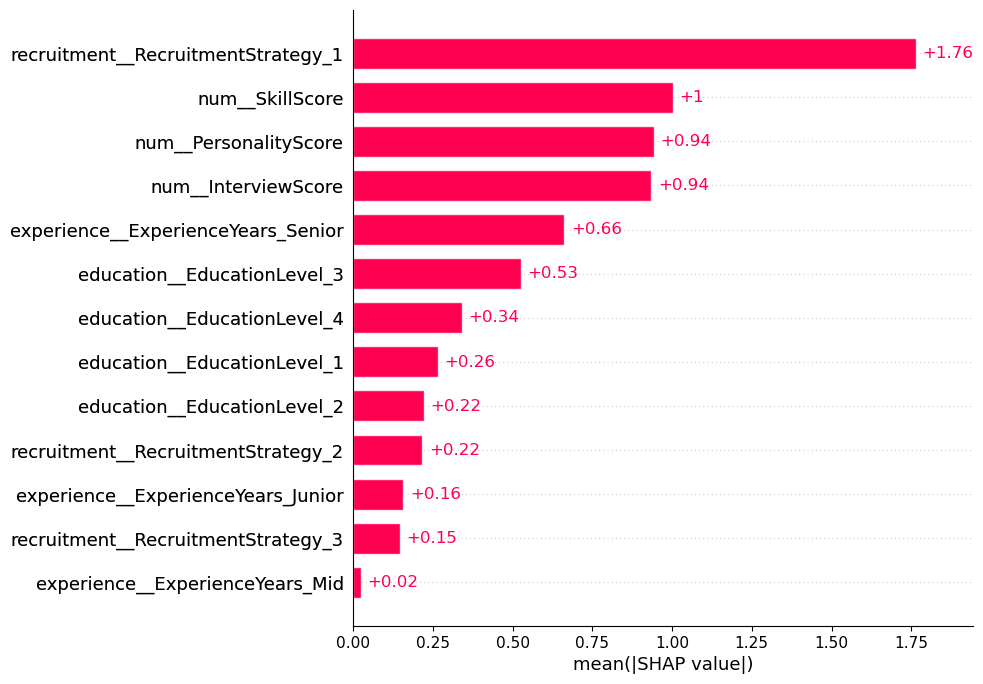

In [40]:
import shap
import matplotlib.pyplot as plt

# Buat explainer khusus untuk tree-based model
explainer = shap.TreeExplainer(load_model)

# Hitung shap values untuk X_test_trans
shap_values = explainer(X_test_trans)

# Plot Top 10 feature importance versi SHAP
# shap.summary_plot(shap_values, X_test_trans, plot_type="bar", max_display=13)
shap_values.display_data = shap.datasets.adult(display=True)[0].values
shap.plots.bar(shap_values, max_display=13)

In [23]:
explainer = dx.Explainer(load_model, X_test_trans, y_test, label="XGBoost")

Preparation of a new explainer is initiated

  -> data              : 300 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 300 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost
  -> predict function  : <function yhat_proba_default at 0x000001BA9262CB80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000671, mean = 0.298, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.978, mean = 0.0119, max = 0.996
  -> model_info        : package xgboost

A new explainer has been created!


In [24]:
fi = explainer.model_parts()

In [26]:
fi.plot(max_vars=12)

C:\Users\Perfecto\AppData\Local\Temp\ipykernel_10840\3566987198.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




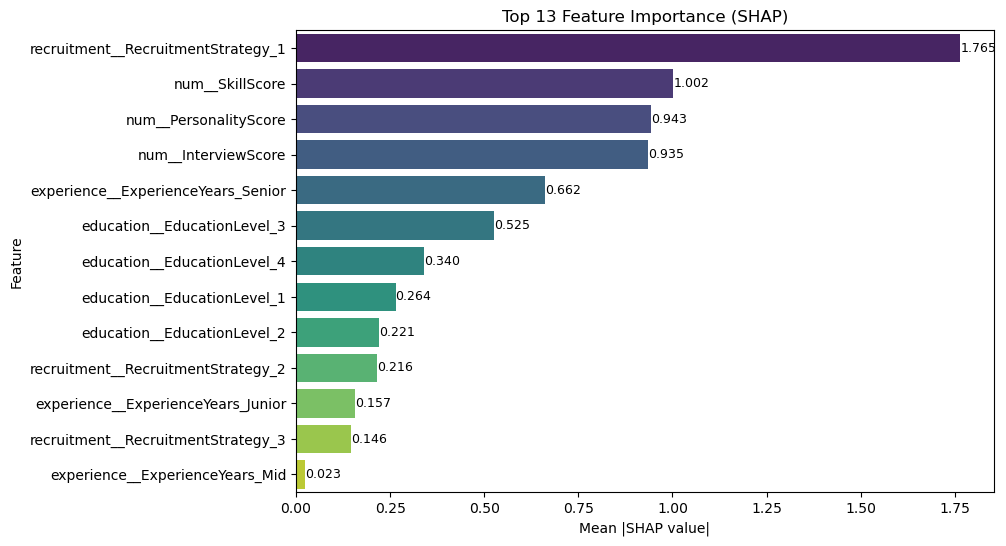

In [34]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Hitung SHAP Values ===
explainer = shap.TreeExplainer(load_model)
shap_values = explainer.shap_values(X_test_trans)

# === Ambil importance ===
# Jika model binary classification, shap_values bisa list (ambil indeks 1)
if isinstance(shap_values, list):
    shap_vals = shap_values[1]  # class positif
else:
    shap_vals = shap_values

# Mean absolute shap value per fitur
shap_importance = np.abs(shap_vals).mean(axis=0)

# Buat dataframe untuk visualisasi
importance_df = pd.DataFrame({
    "feature": X_test_trans.columns,
    "importance": shap_importance
}).sort_values(by="importance", ascending=False).head(13)

# === Plot ===
plt.figure(figsize=(9,6))
sns.barplot(
    data=importance_df,
    x="importance",
    y="feature",
    palette="viridis"
)

# Tambahkan nilai di ujung batang
for i, (val) in enumerate(importance_df["importance"]):
    plt.text(val, i, f"{val:.3f}", va="center", ha="left", fontsize=9)

plt.title("Top 13 Feature Importance (SHAP)")
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Feature")
plt.show()
